# Progetto Finale di FESI: Segmentazione di Un'immagine
***

## Introduzione 
Dato un dataset di immagini lo scopo dell'esperienza è quello di segmentare delle cellule di malaria, con lo scopo di "separare" le cellule dalla malattia

### Quesito --> Cosa costituisce una buona segmentazione?

Come è stato detto precedemtemente la segmentazione è un processo di partizionamento di un'immagine digitale in diverse regioni significative, ognuna delle quali rappresenta un oggetto o una parte di esso presente nella scena. Una segmentazione è considerata "buona" quando soddisfa i seguenti criteri:
- Tutti i pixel all'interno di una stessa regione dovrebbero avere **caratteristiche simili** (colore, intensità, texture) tra loro.
- Le **regioni adiacenti** dovrebbero essere **il più possibile diverse tra loro**, in modo da evidenziare i confini degli oggetti.
- La segmentazione dovrebbe produrre **risultati** che siano intuitivi e **coerenti** con la nostra **percezione visiva degli oggetti** presenti nell'immagine.
- **I confini tra le regioni dovrebbero coincidere con i confini reali degli oggetti presenti nell'immagine.

## 1. Inizio importando le librerie necessarie per lo svolgimento dell'esperienza



In [339]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import measure, morphology

## 2. Analisi del Dataset e Pre-Processing dell'immagine

L'analisi del Dataset consiste nello studiare le caratteristiche delle immagini fornite, identificando le sfide principali (variazioni di colore, intensità, dimensioni) e adottando visualizzazioni appropriate (inclusi istogrammi). 

Le immagini sono tra loro molto simili, le differenze a primo impatto tra quest'ultime sono la gamma di colore e le dimensioni ma non solo.
Infatti gioca un ruolo importante nell'analisi anche la struttura interna del parassita, compreso il suo contorno: <br> 
- Il contorno del parassita può essere netto e definito, oppure sfumato e irregolare e tra un immagine e un'altra notiamo come varia la forma generale del parassita e la sua uniformità lungo tutta l'immagine. 

Infatti quest'ultima è una problematica che mi ha complicato di molto l'analisi nel progetto -->  [(vedi link)](https://drive.google.com/drive/folders/1NobknpSX9yD7Sndq0Q3v3JsxRhD7hHXA?usp=drive_link), la prima immagine possiede tre macchie definite, mentre la numero 26 possiede alcune macchie definite e il resto della malattia ha un colore leggermente più sfumato, ciò mi ha creato problemi nella scelta del valore di sogliatura --> con un valore di sogliatura basso non veniva selezionata la totalità della malattia, mentre con una sogliatura alta veniva presa la totalita della malattia nell'immagine 26, ma venivano presi anche valori che "non c'entravano nulla" della prima immagine.

Come ho detto precedentemente le immagini tra loro variano anche di dimensione, nonchè di risoluzione. <br>
Quindi per evitare problematiche ho scelto di effettuare un resize di ogni immagine portandole a 224 x 224

### Pre-Processing - Che cos'è?

è il processo attraverso cui manipoliamo i dati dell’immagine in modo tale da usare un formato più utilizzabile e significativo. Ciò ci consente di eliminare distorsioni indesiderate e migliorare qualità specifiche essenziali per le applicazioni di visione artificiale.

Alcune tecniche:
- __Resizing:__ effettuare il resizing significa modificare le dimensioni dell’immagine portandole a una dimensione uniforme. Possiamo usare OpenCV “resize”
- __Grayscaling:__ Modificare il colore di un’immagine portandola ad una scala di grigi. Ciò può semplificare i dati e ridurre il carico per alcuni algoritmi
- __Noise reduction, Normalization:__ La normalizzazione regola i valori di intensità dei pixel su un intervallo desiderato, spesso compreso tra 0 e 1. Ciò può migliorare le prestazioni dei modelli di machine learning. Applicare alcune tecniche di filtraggio (smoothing, blurring) per rimuovere del “rumore” non voluto
- __Binarization:__ Converts le immagini in scala di grigi in immagini con valori binari, ovvero bianco e nero → effettuo Thresholding
- __Miglioramento del Contrasto:__ il contrasto delle immagini può essere regolato utilizzando l'equalizzazione dell'istogramma

Fa parte del Pre-Processing anche la scelta dello spazio di colore in cui andare a lavorare. <br>
Una volta caricate nel notebook le immagini appartengono al classico spazio di colore RGB, tuttavia questo spazio di colore non è molto adatto alla segmentazione:

**Questo perchè i colori vengono rappresentati come una combinazione di canali *interdipendenti* , quindi la modifica di un singolo canale va a modificare di molto anche la percezione degli altri due. Ad esempio, una variazione nella luminosità può influenzare sia il rosso che il verde e il blu, rendendo difficile separare le informazioni relative al colore da quelle relative all'illuminazione. Inoltre lo spazio RGB non è progettato per rappresentare in modo accurato la percezione umana del colore. Ad esempio, due colori che sembrano molto simili all'occhio umano possono avere valori RGB molto diversi. Ovviamente è comunque possibile effettuare una buona segmentazione anche in RGB, ma se vogliamo facilitare e rendere più efficente la segmentazione conviene spostarci in degli spazi di colore a componente indipendente: ovvero che separano le informazioni sul colore da quelle sulla luminosità e sulla saturazione, questi spazi facilitano l'estrazione delle caratteristiche rilevanti per la segmentazione; alcuni esempi possono essere HSV, HSL o LAB**

La differenza sostanziale tra HSV e LAB sta nel fatto che HSV è ideale se il colore della zona che io voglio segmentare è ben distinto dal resto della cellula. Mentre LAB è più utile se si preferisce lavorare con differenze cromatiche meno evidenti. Visto che il metodo che dobbiamo implementare deve essere funzionale per tutto il dataset, e al suo interno sono presenti anche immagini dove la differenza tra malattia e cellula non è così marcata ho preferito lavorare sfruttando **LAB**.

#### Come Funziona LAB?
Lo spazio di colori LAB è pensato per rappresentare meglio la percezione dei colori dell'occhio umano. Di conseguenza vengono usati tre canali differenti:
- **L:** Rappresenta la luminosità, in un range da 0 (nero) a 100 (bianco)
- **A:** Rappresenta la componente rosso-verde: valori positivi indicano tonalità tendenti al rosso, mentre valori negativi indicano tonalità tendenti al verde.
- **B:**  Rappresenta la componente giallo-blu. Valori positivi indicano tonalità tendenti al giallo, mentre valori negativi indicano tonalità tendenti al blu.

La segmentazione con LAB risulta quindi vantaggiosa perchè le informazioni cromatiche, sul canale a e sul canale b, sono separate dalle informazioni sulla luminosità, contenute invece nel canale L.
<br> Inoltre siccome il canale B rappresenta la componente giallo blu, e la malattia ha una forte componente blu (essendo viola), ho scelto di effettuare le analisi su questo canale

#### Tecniche Di Normalizzazione utilizzate
Erosione dilatazione, ...


Text(0.5, 1.0, 'B')

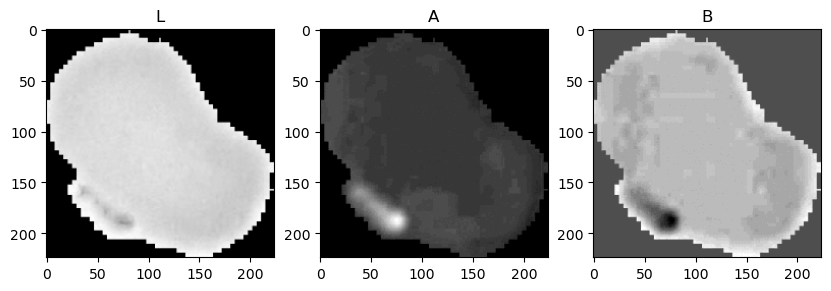

In [340]:
# Carico l'immagine in RGB
image = Image.open('FESI/Progetto/malaria/malaria/parasite (4).png').convert("RGB")
image_array = np.array(image) 

# Converto l'immagine da RGB a LAB e ridimensionamento 

scaled_image = cv2.resize(image_array, (224, 224), interpolation=cv2.INTER_AREA)

image_lab = cv2.cvtColor(scaled_image, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(image_lab)

# Normalizzazione della luminosità
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l)

# Rimozione del rumore (opzionale)
l_smooth = cv2.GaussianBlur(l_clahe, (5, 5), 0)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(l, cmap="gray")
plt.title("L")

plt.subplot(1,3,2)
plt.imshow(a, cmap="gray")
plt.title("A")

plt.subplot(1,3,3)
plt.imshow(b, cmap="gray")
plt.title("B")

## 3. Implementazione della Segmentazione tramite una sogliatura (Thresholding)

(Capire cos'è e come si usa un cluster)

cv2.THRESH_BINARY:

I pixel con intensità sopra la soglia diventano bianchi (255).
I pixel con intensità sotto la soglia diventano neri (0).
 
cv2.THRESH_BINARY_INV:

I pixel con intensità sopra la soglia diventano neri (0).
I pixel con intensità sotto la soglia diventano bianchi (255).

...

Dopo aver effettuato la sogliatura procedo con un'operazione di "Opening", ovvero una operazione di erosione seguita da una dilatazione, con lo scopo di rimuovere il rumore.

- EROSIONE: Questa operazione erode i confini dell'oggetto in primo piano. Funziona creando un kernel di convoluzione e passandolo sull'immagine.Questa operazione è efficace per rimuovere          piccoli rumori bianchi ottenuti dopo la sogliatura

- DILATAZIONE: Questa operazione è l'esatto opposto dell'erosione --> Serve perchè l'operazione di erosione potrebbe rimpicciolire gli oggetti, di conseguenza l'operazione di dilatazione ci consente di mantenere le dimensioni degli oggetti senza alterarne il rumore.

...

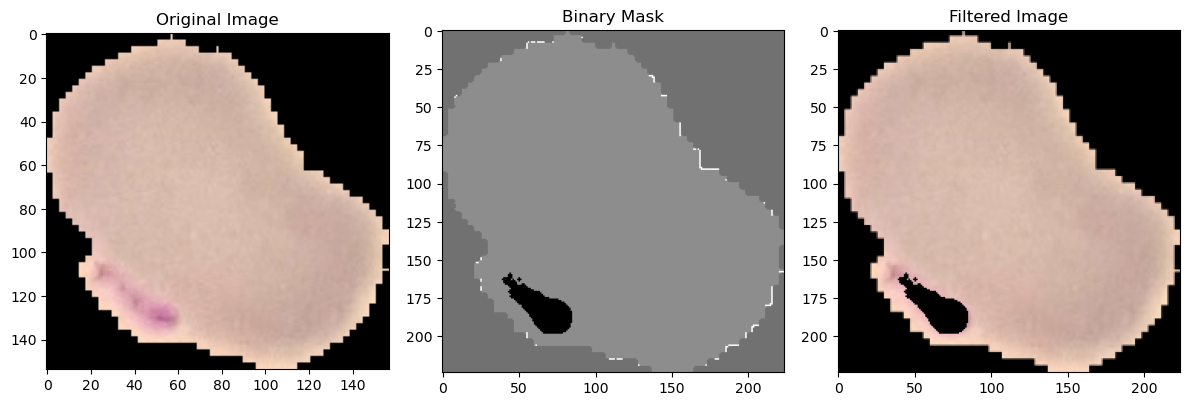

In [ ]:
# Sogliatura adattiva sul canale b*
weights = [0.5, 0.4]  # Regola i pesi per bilanciare l'importanza di B e A
b_thresh = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
a_thresh = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
combined_thresh = (weights[0] * b_thresh) + (weights[1] * a_thresh)

_, mask_lab_b = cv2.threshold(combined_thresh.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C + cv2.THRESH_BINARY, 11,2)

# Operazioni morfologiche per pulire la maschera
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned_mask = cv2.morphologyEx(mask_lab_b, cv2.MORPH_CLOSE, kernel)

# Rimozione dei componenti piccoli
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned_mask, connectivity=8)
min_size = 50  # Regola in base alla dimensione
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] < min_size:
        cleaned_mask[labels == i] = 0

# Applica la maschera
segmented_image = cv2.bitwise_and(scaled_image, scaled_image, mask=cleaned_mask)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Binary Mask")
plt.imshow(cleaned_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Filtered Image")
plt.imshow(segmented_image)

plt.tight_layout()
plt.show()
